<h1>Primo Progetto<h1>

In [7]:
# Importo le librerie richieste
import pandas as pd
from serpapi import GoogleScholarSearch
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

In [5]:
GoogleScholarSearch.SERP_API_KEY = "2ffb3e2b7c2820b111bb5259892890ee2691e1afe058a01fe13f62e6ceecbb8d"

#### 1 | Utilizzo della libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati nel file nodes.csv

In [3]:
# Importo il file nodes.csv
df = pd.read_csv('data/nodes.csv')
display(df)

,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,Computer Science
1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"Computer Science, Crowdsourcing"
2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"Artificial Intelligence, Crowdsourcing and Hum..."
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"Information retrieval, mobile systems, scholar..."
4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"Information Retrieval, Text Analytics, Data Sc..."
5,Gianluca Demartini,Associate Professor at the University of Queen...,PCAiILsAAAAJ,5348,"Information Retrieval, Semantic Web, Human Com..."
6,Eddy Maddalena,"Università degli Studi di Udine, Italy",egHDpFkAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."


<h1>NON RUNNARE FINO A NUOVO ORDINE, SERVE SOLO PER SCARICARE I DATI<h1>

```python

In [ ]:

updated_df = pd.DataFrame(columns=['author_id', 'cited_by', 'interests'])

# Itero su ogni autore del dataframe
for index, row in df.iterrows():
    author_name = row['name']
    author_affliation = row['affiliations']
        
    params = {
        "engine" : "google_scholar_profiles",
        "hl": "en",
        "mauthors":f'{author_name},{author_affliation}'
    }
    search = GoogleScholarSearch(params)
    results = search.get_dict()['profiles']
    
    for profile in results:
        author_id = profile['author_id']
        cited_by = profile['cited_by']
        
        interests = []
        
        for interest in profile.get('interests', ):
            title = interest.get('title', '')
            interests.append(title)
    
    interests_str = ', '.join(interests)
    
    # Aggiungo una nuova riga al dataframe updated_df
    new_row = {'author_id': author_id, 'cited_by': cited_by, 'interests': interests_str}
    updated_df = pd.concat([updated_df, pd.DataFrame([new_row])], ignore_index=True)

df = pd.merge(df, updated_df, left_index=True, right_index=True)
display(df)



In [ ]:
# Sovrascrivo il file nodes.csv con le nuove informazioni trovate
df.to_csv('data/nodes.csv', index=False)

#### 2 | Per ogni autore utilizzo il suo ID per accedere al relativo profilo GoogleScholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI

In [12]:
df = pd.read_csv('data/nodes.csv')

# Creo le liste vuote per memorizzare i nomi dei co-autori e successivamente le loro informazioni
co_authors = []
info_co_authors = []

# Itero su ogni autore del dataframe
for index, row in df.iterrows():
    author_id = row['author_id']
    author_name = row['name']    
        
    params = {
        "engine" : "google_scholar_author",
        "hl": "en",
        "author_id": author_id  
    }
    
    search = GoogleScholarSearch(params)
    results = search.get_dict()['co_authors']
    #print(results)
    
    # Estraggo i nomi dei co-autori per ogni autore originario, catturo il legame che c'è tra ogni autore con i suoi co-autori
    # Sto quindi catturando gli archi del mio grafo
    for co_author in results:
        co_authors.append(
            {
                "author1" : author_name,
                "author2" : co_author['name']
            }
        )
        
    # Estraggo le informazioni relative ai co-autori che sono in grado di estrarre già tramite questa ricerca SerpAPI
    for co_author in results:
        info_co_authors.append(
            {
                "name" : co_author['name'],
                "affiliations": co_author.get('affiliations'),
                "author_id" : co_author['author_id']
            }
        )
    
    
coauthors_df = pd.DataFrame(columns=['name', 'affiliations', 'author_id'])
coauthorship_df = pd.DataFrame(columns=['author1','author2'])

coauthors_df = pd.concat([coauthors_df, pd.DataFrame(info_co_authors)], ignore_index=True)
coauthorship_df = pd.concat([coauthorship_df, pd.DataFrame(co_authors)], ignore_index=True)

# il dataframe coauthors_df corrisponde al dataframe contenente le informazioni, ancora non complete, sui nodi del grafo 
display(coauthors_df)
# il dataframe coauthorship_df corrisponde al dataframe contenente le informazioni, complete, sugli archi del grafo 
display(coauthorship_df)




,name,affiliations,author_id
0,Kevin Roitero,University of Udine,1xd52jMAAAAJ
1,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ
2,Gianluca Demartini,Associate Professor at the University of Queen...,PCAiILsAAAAJ
3,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ
4,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ
...,...,...,...
122,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ
123,Jonathon Hare,Professor of Machine Learning and Computer Vis...,UFeON5oAAAAJ
124,Carlo Alberto Beltrami,"Professore, Università di Udine",EZrMWWMAAAAJ
125,Richard Gomer,University of Southampton,5ZTLglQAAAAJ


,author1,author2
0,David La Barbera,Kevin Roitero
1,David La Barbera,Stefano Mizzaro
2,David La Barbera,Gianluca Demartini
3,David La Barbera,Damiano Spina
4,David La Barbera,Michael Soprano
...,...,...
122,Eddy Maddalena,Pavlos Vougiouklis
123,Eddy Maddalena,Jonathon Hare
124,Eddy Maddalena,Carlo Alberto Beltrami
125,Eddy Maddalena,Richard Gomer


In [13]:

# Per trovare 'cited_by' e 'interests' dei co-autori devo fare un'ulteriore ricerca sull base dei loro nomi e dopodichè posso aggiungere queste info al dataframe
# Itero sulla lista co_authors che contiene tutti i nomi dei co_authori, per ognuno di loro effettuo una ricerca tramite nome
info_df = pd.DataFrame(columns=['cited_by', 'interests'])


for index, co_author in coauthors_df.iterrows():
    co_author_name = row['name']
    co_author_affiliation = row['affiliations']
    
    
    params = {
        "engine" : "google_scholar_profiles",
        "hl": "en",
        "mauthors":f'{co_author_name},{co_author_affiliation}'
    }
    
    search = GoogleScholarSearch(params)
    results = search.get_dict()['profiles']
    
    for profile in results:
        cited_by = profile['cited_by']
        
        interests = []
        
        for interest in profile.get('interests', ):
            title = interest.get('title', '')
            interests.append(title)
    
    interests_str = ', '.join(interests)
    
    # Add the information to the coauthors_df dataframe
    new_row = {'cited_by': cited_by, 'interests': interests_str}
    info_df = pd.concat([info_df, pd.DataFrame([new_row])], ignore_index=True)
    
coauthors_df = pd.merge(coauthors_df, info_df, left_index=True, right_index=True)    
display(coauthors_df)

,name,affiliations,author_id,cited_by,interests
0,Kevin Roitero,University of Udine,1xd52jMAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
1,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
2,Gianluca Demartini,Associate Professor at the University of Queen...,PCAiILsAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
3,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
4,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
...,...,...,...,...,...
122,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
123,Jonathon Hare,Professor of Machine Learning and Computer Vis...,UFeON5oAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
124,Carlo Alberto Beltrami,"Professore, Università di Udine",EZrMWWMAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
125,Richard Gomer,University of Southampton,5ZTLglQAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."


In [19]:
nodes = pd.concat([df, coauthors_df], ignore_index=True).drop_duplicates()
display(nodes)
nodes.to_csv('data/nodes.csv', index=False)

# TODO: sono da rimuovere le coppie simmetriche????
edges = coauthorship_df
edges.to_csv('data/edges.csv', index=False)


,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,Computer Science
1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"Computer Science, Crowdsourcing"
2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"Artificial Intelligence, Crowdsourcing and Hum..."
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"Information retrieval, mobile systems, scholar..."
4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"Information Retrieval, Text Analytics, Data Sc..."
...,...,...,...,...,...
128,Dante Degl'Innocenti,Datamantix,Ay6L7NsAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
129,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
130,Jonathon Hare,Professor of Machine Learning and Computer Vis...,UFeON5oAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."
131,Carlo Alberto Beltrami,"Professore, Università di Udine",EZrMWWMAAAAJ,553,"Information Retrieval, Crowdsourcing, Data Sci..."


<h1>RUNNIAMO DA QUA IN GIU<h1>

In [4]:
nodes = pd.read_csv('data/nodes.csv')
edges = pd.read_csv('data/edges.csv')

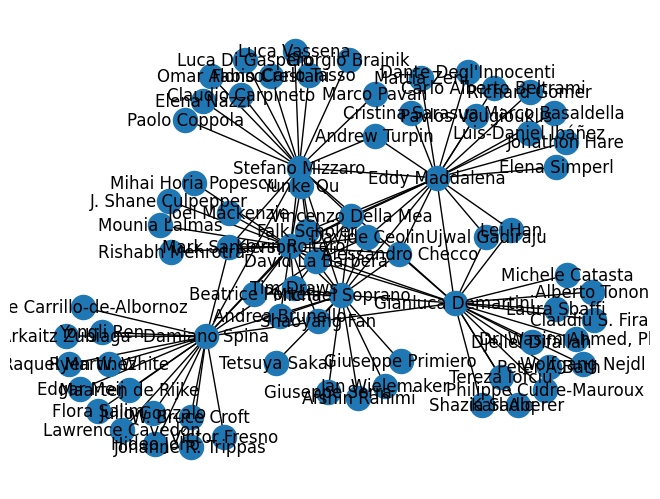

In [28]:
grafo = nx.Graph()

for nome in nodes['name']: 
    grafo.add_node(nome)

for index, row in edges.iterrows():
    grafo.add_edge(row['author1'], row['author2'])
     
nx.draw(grafo, with_labels=True)
plt.show()

nx.write_gml(grafo,"graphs/coauthorship_graph.gml")


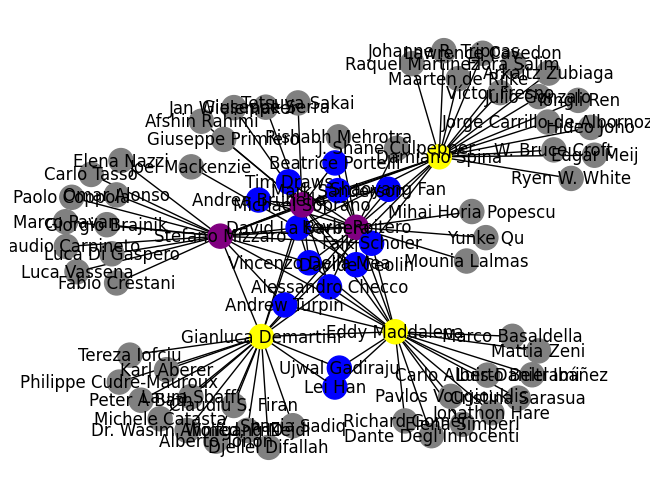

<Figure size 640x480 with 0 Axes>

In [29]:
#coloraggio nodi, grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
#giallo per nodi con grado maggiore di 20

node_colors = []
for node, degree in grafo.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')

# Disegna il grafo con i nodi colorari
nx.draw(
    grafo, 
    with_labels=True, 
    pos = nx.spring_layout(grafo),
    node_color=node_colors)

# Mostra il grafo
plt.show()
# Salvo il graf come pdf
plt.savefig('visualizations/graph.pdf', format='pdf')




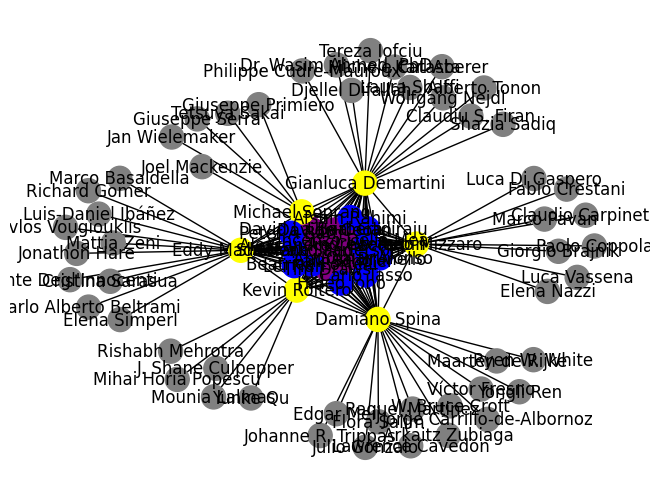

<Figure size 640x480 with 0 Axes>

In [31]:

# Print the new edges created using Preferential Attachment
preds = nx.preferential_attachment(grafo)

# Create an empty dataframe
df_preds = pd.DataFrame(columns=['author1', 'author2', 'p'])

# Iterate over the preds tuple and add the values to the dataframe
for u, v, p in preds:
    new_row = {'author1': u, 'author2': v, 'p': p}
    df_preds = pd.concat([df_preds, pd.DataFrame([new_row])], ignore_index=True)

df_preds = df_preds.sort_values(by='p', ascending=False)
#display(df_preds)

grafo_preferential_attachment = grafo

for index, row in df_preds.head(50).iterrows():
    author1 = row['author1']
    author2 = row['author2']
    grafo_preferential_attachment.add_edge(author1, author2)
    
    
# ricalcolo i gradi per il nuovo grafo aumentato

node_colors = []
for node, degree in grafo_preferential_attachment.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')
    
nx.draw(
    grafo_preferential_attachment, 
    with_labels=True, 
    pos = nx.spring_layout(grafo_preferential_attachment),
    node_color=node_colors)    
plt.show()    

nx.write_gml(grafo,"graphs/extended_coauthorship_graph.gml")
plt.savefig('visualizations/extended_graph.pdf', format='pdf')




In [32]:
# Calcolo delle metriche per il grafo
clustering_coeff_grafo = nx.average_clustering(grafo)
center_grafo = nx.center(grafo)
radius_grafo = nx.radius(grafo)
medium_distance_grafo = nx.average_shortest_path_length(grafo)
transitivity_grafo = nx.transitivity(grafo)
omega_grafo = nx.omega(grafo)
sigma_grafo = nx.sigma(grafo)

In [33]:
# Calcolo delle metriche per il grafo esteso
clustering_coeff_grafo_pa = nx.average_clustering(grafo_preferential_attachment)
center_grafo_pa = nx.center(grafo_preferential_attachment)
radius_grafo_pa = nx.radius(grafo_preferential_attachment)
medium_distance_grafo_pa = nx.average_shortest_path_length(grafo_preferential_attachment)
transitivity_grafo_pa = nx.transitivity(grafo_preferential_attachment)
omega_grafo_pa = nx.omega(grafo_preferential_attachment)
sigma_grafo_pa = nx.sigma(grafo_preferential_attachment)

In [34]:

info_graphs = pd.DataFrame(columns=['average clustering coefficient', 'center', 'radius', 'medium distance', 'transitivity', 'omega', 'sigma'])

# Dataframe 
info_graphs.loc[0] = {'average clustering coefficient': clustering_coeff_grafo, 
                      'center': center_grafo, 
                      'radius': radius_grafo, 
                      'medium distance': medium_distance_grafo, 
                      'transitivity': transitivity_grafo, 

                      'omega': omega_grafo, 
                      'sigma': sigma_grafo
                     }

info_graphs.loc[1] = {'average clustering coefficient': clustering_coeff_grafo_pa, 
                      'center': center_grafo_pa, 
                      'radius': radius_grafo_pa, 
                      'medium distance': medium_distance_grafo_pa, 

                      'transitivity': transitivity_grafo_pa, 
                      'omega': omega_grafo_pa, 
                      'sigma': sigma_grafo_pa
                     }

display(info_graphs)

,average clustering coefficient,center,radius,medium distance,transitivity,omega,sigma
0,0.249571,"[David La Barbera, Michael Soprano, Kevin Roit...",2,2.315088,0.431235,0.000872,0.999636
1,0.249571,"[David La Barbera, Michael Soprano, Kevin Roit...",2,2.315088,0.431235,0.000851,0.999515


In [36]:
# Calcolo delle metriche per il grafo
degree_centrality_grafo = nx.degree_centrality(grafo)
betwenness_centrality_grafo = nx.betweenness_centrality(grafo)
closeness_centrality_grafo = nx.closeness_centrality(grafo)
page_rank_grafo = nx.page
HITS_grafo = nx.hits(grafo)
print(HITS_grafo)

ModuleNotFoundError: No module named 'scipy'